In [ ]:
!pip install geopandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

## Airlines data

we analyze both market and segment, using segment https://transportation.libanswers.com/faq/166158

In [29]:
import os

DATA_ROOT = 'data'

domestic_flights = pd.read_csv(os.path.join(DATA_ROOT, 'T_T100D_SEGMENT_ALL_CARRIER.csv'))
domestic_flights = domestic_flights[domestic_flights['PASSENGERS'] > 0]
domestic_flights = domestic_flights[domestic_flights['DISTANCE'] > 0]
domestic_flights = domestic_flights[domestic_flights['RAMP_TO_RAMP'] > 0]
domestic_flights.columns = domestic_flights.columns.str.lower()
domestic_flights.head()

departures_performed  seats  passengers  distance  ramp_to_ramp  \
12753                   1.0    0.0         1.0    1107.0         151.0   
12754                   1.0    0.0         1.0    1107.0         156.0   
13364                   1.0    1.0         1.0       9.0          11.0   
13365                   1.0    1.0         1.0       9.0          12.0   
13366                   1.0    1.0         1.0      11.0          13.0   

      unique_carrier  airline_id                   unique_carrier_name  \
12753            AMQ       20201                   Ameristar Air Cargo   
12754            AMQ       20201                   Ameristar Air Cargo   
13364             7S       20330  Ryan Air f/k/a Arctic Transportation   
13365             7S       20330  Ryan Air f/k/a Arctic Transportation   
13366             7S       20330  Ryan Air f/k/a Arctic Transportation   

      carrier                          carrier_name  origin_airport_id origin  \
12753     AMQ                   Ameristar Air Cargo              11697    FLL   
12754     AMQ                   Ameristar Air Cargo              15024    STT   
13364      7S  Ryan Air f/k/a Arctic Transportation              14493    RDV   
13365      7S  Ryan Air f/k/a Arctic Transportation              14880    SLQ   
13366      7S  Ryan Air f/k/a Arctic Transportation              10996    CHU   

      origin_state_abr  dest_airport_id dest dest_state_abr  aircraft_type  \
12753               FL            15024  STT             VI            635   
12754               VI            11697  FLL             FL            635   
13364               AK            14880  SLQ             AK             35   
13365               AK            14493  RDV             AK             35   
13366               AK            10304  ANI             AK             35   

       year  quarter  month  
12753  2019        4     10  
12754  2019        4     10  
13364  2019        3      8  
13365  2019        2      5  
13366  2019        4     11

In [30]:
domestic_flights.describe()

departures_performed          seats     passengers       distance  \
count         322093.000000  322093.000000  322093.000000  322093.000000   
mean              26.947540    3090.670521    2548.013471     751.648729   
std               40.720759    5408.373353    4560.157768     611.161368   
min                1.000000       0.000000       1.000000       1.000000   
25%                2.000000     173.000000     124.000000     292.000000   
50%               11.000000    1120.000000     880.000000     612.000000   
75%               32.000000    3960.000000    3205.000000    1032.000000   
max             1053.000000  108032.000000   86623.000000    7264.000000   

        ramp_to_ramp     airline_id  origin_airport_id  dest_airport_id  \
count  322093.000000  322093.000000      322093.000000    322093.000000   
mean     3415.480852   20176.283033       12755.161720     12747.881963   
std      5529.337651     475.043082        1562.388145      1560.590119   
min         5.000000   19393.000000       10005.000000     10005.000000   
25%       209.000000   19805.000000       11292.000000     11292.000000   
50%      1278.000000   20304.000000       12889.000000     12889.000000   
75%      4668.000000   20409.000000       14100.000000     14100.000000   
max    140068.000000   21974.000000       16876.000000     16875.000000   

       aircraft_type      year        quarter          month  
count  322093.000000  322093.0  322093.000000  322093.000000  
mean      616.597023    2019.0       2.516754       6.559525  
std       159.861747       0.0       1.115596       3.446743  
min        10.000000    2019.0       1.000000       1.000000  
25%       614.000000    2019.0       2.000000       4.000000  
50%       638.000000    2019.0       3.000000       7.000000  
75%       694.000000    2019.0       4.000000      10.000000  
max       889.000000    2019.0       4.000000      12.000000

In [31]:
airports = pd.read_csv(os.path.join(DATA_ROOT, 'airports.csv'))
airports = airports[['name', 'city', 'country', 'iata', 'lat', 'lon']]
airports.head()

name          city  \
0                               Goroka Airport        Goroka   
1                               Madang Airport        Madang   
2                 Mount Hagen Kagamuga Airport   Mount Hagen   
3                               Nadzab Airport        Nadzab   
4  Port Moresby Jacksons International Airport  Port Moresby   

            country iata       lat         lon  
0  Papua New Guinea  GKA -6.081690  145.391998  
1  Papua New Guinea  MAG -5.207080  145.789001  
2  Papua New Guinea  HGU -5.826790  144.296005  
3  Papua New Guinea  LAE -6.569803  146.725977  
4  Papua New Guinea  POM -9.443380  147.220001

In [32]:
domestic_flights = pd.merge(domestic_flights, airports, left_on='origin', right_on='iata', how='left')
domestic_flights = pd.merge(domestic_flights, airports, left_on='dest', right_on='iata', how='left', suffixes=('_origin', '_dest'))
domestic_flights.head()

departures_performed  seats  passengers  distance  ramp_to_ramp  \
0                   1.0    0.0         1.0    1107.0         151.0   
1                   1.0    0.0         1.0    1107.0         156.0   
2                   1.0    1.0         1.0       9.0          11.0   
3                   1.0    1.0         1.0       9.0          12.0   
4                   1.0    1.0         1.0      11.0          13.0   

  unique_carrier  airline_id                   unique_carrier_name carrier  \
0            AMQ       20201                   Ameristar Air Cargo     AMQ   
1            AMQ       20201                   Ameristar Air Cargo     AMQ   
2             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
3             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
4             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   

                           carrier_name  ...  country_origin iata_origin  \
0                   Ameristar Air Cargo  ...   United States         FLL   
1                   Ameristar Air Cargo  ...  Virgin Islands         STT   
2  Ryan Air f/k/a Arctic Transportation  ...             NaN         NaN   
3  Ryan Air f/k/a Arctic Transportation  ...   United States         SLQ   
4  Ryan Air f/k/a Arctic Transportation  ...   United States         CHU   

  lat_origin  lon_origin                                        name_dest  \
0  26.072599  -80.152702                            Cyril E. King Airport   
1  18.337299  -64.973396  Fort Lauderdale Hollywood International Airport   
2        NaN         NaN                                Sleetmute Airport   
3  61.700500 -157.166000                                              NaN   
4  61.579102 -159.216003                                    Aniak Airport   

         city_dest    country_dest  iata_dest   lat_dest    lon_dest  
0       St. Thomas  Virgin Islands        STT  18.337299  -64.973396  
1  Fort Lauderdale   United States        FLL  26.072599  -80.152702  
2        Sleetmute   United States        SLQ  61.700500 -157.166000  
3              NaN             NaN        NaN        NaN         NaN  
4            Aniak   United States        ANI  61.581600 -159.542999  

[5 rows x 32 columns]

In [45]:
# dropping flights that are not within the US (samoa, puerto rico, etc.)

domestic_flights = domestic_flights[domestic_flights['country_origin'] == 'United States']
domestic_flights = domestic_flights[domestic_flights['country_dest'] == 'United States']

In [46]:
domestic_flights = domestic_flights.dropna(subset=['lat_origin', 'lon_origin', 'lat_dest', 'lon_dest'])
domestic_flights.rename(columns={'origin': 'airport_origin', 'dest': 'airport_dest'}, inplace=True)

In [ ]:
"""# converting sched_dep_time to 'std' - Scheduled time of departure
airlines_full['std'] = airlines_full.dep_time.astype(str).str[:2] + ':' + airlines_full.dep_time.astype(str).str[2:4] + ':00'

# converting sched_arr_time to 'sta' - Scheduled time of arrival
airlines_full['sta'] = airlines_full.arr_time.astype(str).str[:2] + ':' + airlines_full.arr_time.astype(str).str[2:4] + ':00'

# date
airlines_full['date'] = pd.to_datetime(airlines_full[['year', 'month', 'day']])

# dropping the year, month and day columns
airlines_full.drop(['year', 'month', 'day'], axis=1, inplace=True)"""

"# converting sched_dep_time to 'std' - Scheduled time of departure\nairlines_full['std'] = airlines_full.dep_time.astype(str).str[:2] + ':' + airlines_full.dep_time.astype(str).str[2:4] + ':00'\n\n# converting sched_arr_time to 'sta' - Scheduled time of arrival\nairlines_full['sta'] = airlines_full.arr_time.astype(str).str[:2] + ':' + airlines_full.arr_time.astype(str).str[2:4] + ':00'\n\n# date\nairlines_full['date'] = pd.to_datetime(airlines_full[['year', 'month', 'day']])\n\n# dropping the year, month and day columns\nairlines_full.drop(['year', 'month', 'day'], axis=1, inplace=True)"

In [47]:
len(domestic_flights['airport_origin'].unique())

826

In [48]:
len(domestic_flights['airport_dest'].unique())

820

## Graph analysis

In [49]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl

# create geopandas dataframe from airlines_full
gdf = gpd.GeoDataFrame(domestic_flights, geometry=gpd.points_from_xy(domestic_flights.lon_origin, domestic_flights.lat_origin))

# create column with coordinates of destination airport geometry
gdf['geometry_dest'] = gpd.points_from_xy(gdf.lon_dest, gdf.lat_dest)
# create movement id for each flight
gdf['movement_id'] = gdf.index + 1

""" 
biggest_airports_us = [
    "ATL",
    "LAX",
    "ORD",
    "DFW",
    "DEN",
    "JFK",
    "SFO",
    "SEA",
    "LAS",
    "MCO"
]

gdf = gdf[(gdf['passengers'] > 0) & (gdf['seats'] < 1000)]
gdf = gdf[gdf['airport_origin'].isin(biggest_airports_us)]
"""

gdf.head()

departures_performed  seats  passengers  distance  ramp_to_ramp  \
4                    1.0    1.0         1.0      11.0          13.0   
5                    1.0    1.0         1.0      11.0          14.0   
7                    1.0    1.0         1.0      11.0          46.0   
13                   1.0    1.0         1.0      20.0          16.0   
14                   1.0    1.0         1.0      20.0          16.0   

   unique_carrier  airline_id                   unique_carrier_name carrier  \
4              7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
5              7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
7              7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
13             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   
14             7S       20330  Ryan Air f/k/a Arctic Transportation      7S   

                            carrier_name  ...  lon_origin         name_dest  \
4   Ryan Air f/k/a Arctic Transportation  ... -159.216003     Aniak Airport   
5   Ryan Air f/k/a Arctic Transportation  ... -159.216003     Aniak Airport   
7   Ryan Air f/k/a Arctic Transportation  ... -159.216003     Aniak Airport   
13  Ryan Air f/k/a Arctic Transportation  ... -160.190994  Shageluk Airport   
14  Ryan Air f/k/a Arctic Transportation  ... -159.569000     Anvik Airport   

   city_dest   country_dest iata_dest   lat_dest    lon_dest  \
4      Aniak  United States       ANI  61.581600 -159.542999   
5      Aniak  United States       ANI  61.581600 -159.542999   
7      Aniak  United States       ANI  61.581600 -159.542999   
13  Shageluk  United States       SHX  62.692299 -159.569000   
14     Anvik  United States       ANV  62.646702 -160.190994   

                       geometry                geometry_dest  movement_id  
4   POINT (-159.21600 61.57910)  POINT (-159.54300 61.58160)            5  
5   POINT (-159.21600 61.57910)  POINT (-159.54300 61.58160)            6  
7   POINT (-159.21600 61.57910)  POINT (-159.54300 61.58160)            8  
13  POINT (-160.19099 62.64670)  POINT (-159.56900 62.69230)           14  
14  POINT (-159.56900 62.69230)  POINT (-160.19099 62.64670)           15  

[5 rows x 35 columns]

In [51]:
gdf.describe()

departures_performed          seats     passengers       distance  \
count         303675.000000  303675.000000  303675.000000  303675.000000   
mean              27.675996    3231.260179    2663.825689     773.603448   
std               40.392556    5505.345128    4640.913819     604.324519   
min                1.000000       0.000000       1.000000       4.000000   
25%                2.000000     181.000000     143.000000     326.000000   
50%               12.000000    1300.000000    1023.000000     632.000000   
75%               34.000000    4104.000000    3343.000000    1037.000000   
max              844.000000  108032.000000   86623.000000    5095.000000   

        ramp_to_ramp     airline_id  origin_airport_id  dest_airport_id  \
count  303675.000000  303675.000000      303675.000000    303675.000000   
mean     3555.214012   20153.570330       12734.242911     12727.194218   
std      5617.861976     460.910144        1540.009777      1538.485114   
min         6.000000   19393.000000       10135.000000     10135.000000   
25%       237.000000   19805.000000       11292.000000     11292.000000   
50%      1465.000000   20304.000000       12889.000000     12889.000000   
75%      4858.000000   20398.000000       14082.000000     14057.000000   
max    140068.000000   21974.000000       16748.000000     16748.000000   

       aircraft_type      year        quarter          month     lat_origin  \
count  303675.000000  303675.0  303675.000000  303675.000000  303675.000000   
mean      634.770245    2019.0       2.516032       6.558778      39.228140   
std       131.468229       0.0       1.117896       3.455503       8.748588   
min        10.000000    2019.0       1.000000       1.000000      19.721399   
25%       614.000000    2019.0       2.000000       4.000000      33.636700   
50%       638.000000    2019.0       3.000000       7.000000      38.944500   
75%       694.000000    2019.0       4.000000      10.000000      41.978600   
max       889.000000    2019.0       4.000000      12.000000      71.285402   

          lon_origin       lat_dest       lon_dest    movement_id  
count  303675.000000  303675.000000  303675.000000  303675.000000  
mean      -98.377691      39.218193     -98.348749  164058.539639  
std        23.728632       8.743398      23.695366   92530.334443  
min      -176.645996      19.721399    -176.645996       5.000000  
25%      -112.012001      33.636700    -112.012001   83754.500000  
50%       -89.976700      38.944500     -89.976700  165782.000000  
75%       -81.308998      41.978600     -81.308998  244394.500000  
max       -68.044800      71.285402     -68.044800  322075.000000

In [53]:
edges = gdf[['airport_origin', 'airport_dest']].values

In [54]:
spatial_network = nx.from_edgelist(edges)

In [55]:
print(f'Number of nodes in the spatial network: {len(spatial_network.nodes())}')
print(f'Number of edges in the spatial network: {len(spatial_network.edges())}')
print(f'Spatial network density: {nx.density(spatial_network)}')

Number of nodes in the spatial network: 844
Number of edges in the spatial network: 11644
Spatial network density: 0.03273121834117601


In [56]:
print(f'The spatial network is directed: {nx.is_directed(spatial_network)}')

The spatial network is directed: False


In [57]:
pos = {v['iata']: (v['lon'], v['lat'])
       for airport, v in
       airports.to_dict('index').items()}

In [80]:
deg = nx.degree(spatial_network)
deg_sizes = [deg[iata] for iata in spatial_network.nodes]

labels = {iata: '' 
          for iata in spatial_network.nodes}

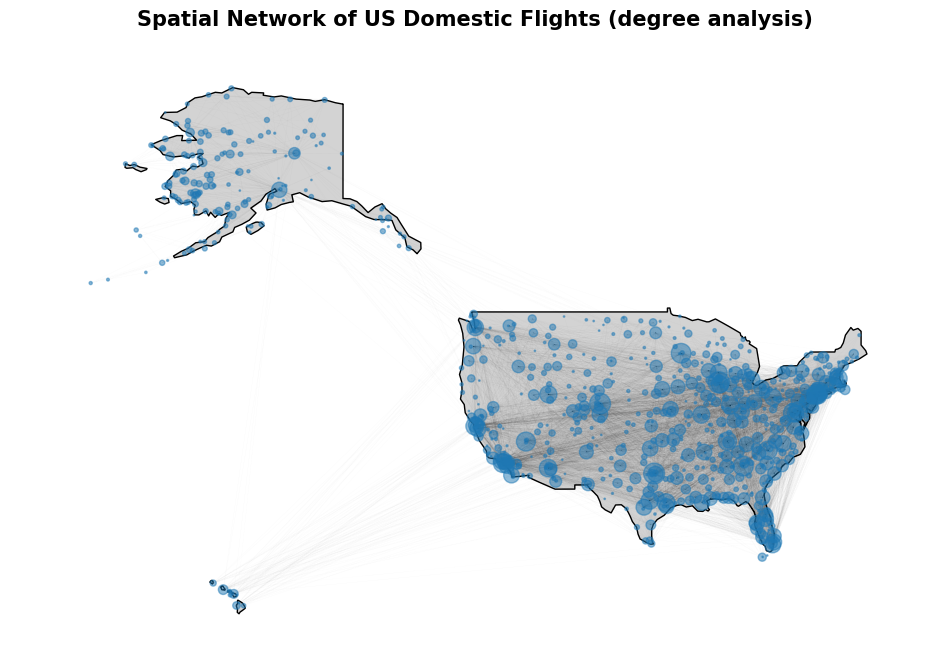

In [81]:
# Map projection
fig, ax = plt.subplots(figsize=(12, 9))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter data for the United States
usa = world[world['name'] == 'United States of America']
usa.plot(ax=ax, color='lightgray', edgecolor='black')

nx.draw_networkx(spatial_network, ax=ax,
                 font_size=3,
                 alpha=.5,
                 width=.0075,
                 node_size=deg_sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.autumn)

# Customize the plot appearance
ax.set_axis_off()

plt.title('Spatial Network of US Domestic Flights (degree analysis)', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

In [130]:
def get_passengers_sizes(passengers_nums):
    passengers_sizes = []
    for iata in spatial_network.nodes:
        passengers_sizes.append(passengers_nums[passengers_nums['airport'] == iata]['passengers'].values)

    passengers_sizes = [row[0] if len(row) > 0 else 0 for row in passengers_sizes]

    passengers_sizes = [size / max(passengers_sizes) * 100 for size in passengers_sizes]
    return passengers_sizes

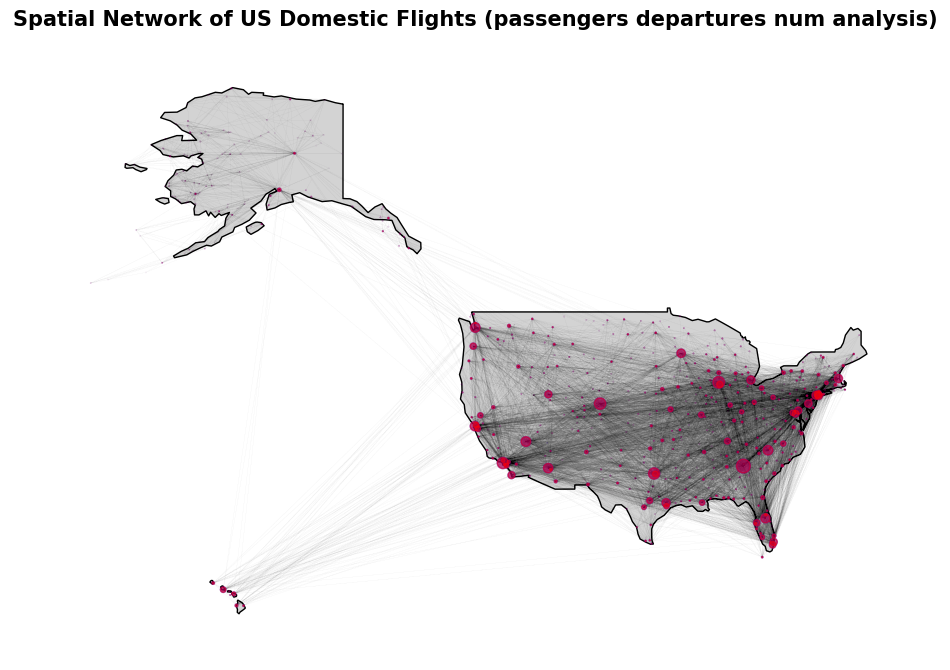

In [141]:
# Map projection
fig, ax = plt.subplots(figsize=(12, 9))
usa.plot(ax=ax, color='lightgray', edgecolor='black')

passengers_departures = domestic_flights.groupby('airport_origin')['passengers'].sum().reset_index()
passengers_departures.rename(columns={'airport_origin': 'airport'}, inplace=True)
passengers_sizes = get_passengers_sizes(passengers_departures)

nx.draw_networkx(spatial_network, ax=ax,
                 font_size=3,
                 alpha=.5,
                 width=.01,
                 node_size=passengers_sizes,
                 labels=labels,
                 pos=pos,
                 node_color='blue',
                 cmap=mpl.colormaps['plasma'])

passengers_arrivals = domestic_flights.groupby('airport_dest')['passengers'].sum().reset_index()
passengers_arrivals.rename(columns={'airport_dest': 'airport'}, inplace=True)
passengers_sizes = get_passengers_sizes(passengers_arrivals)

nx.draw_networkx(spatial_network, ax=ax,
                 font_size=3,
                 alpha=.5,
                 width=.01,
                 node_size=passengers_sizes,
                 labels=labels,
                 pos=pos,
                 node_color='red',
                 cmap=mpl.colormaps['viridis'])

# Customize the plot appearance
ax.set_axis_off()

plt.title('Spatial Network of US Domestic Flights (passengers num analysis)', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

In [142]:
months = [i+1 for i in range(12)]

In [143]:
import networkx as nx
import pandas as pd
from typing import Dict, List

class TemporalNetwork(nx.DiGraph):
    """
    Class representing a temporal directed network.
    The class inherits from `DiGraph` and overrides the `to_undirected` method.
    """
    def __init__(self) -> None:
        super().__init__()

    def to_undirected(self) -> nx.Graph:
        """Function to turn the network from directed to undirected
        Resulting edges weights are obtained as the sum of the directed edges from u to v or v to u divided by their quantity.

        Returns
        -------
        Graph
            The undirected version of the original graph
        """
        undirected_network = nx.Graph()

        undirected_network.add_nodes_from(self.nodes)

        undirected_network.add_edges_from(self.edges(), mean_travel_time=0)

        for u, v, d in self.edges(data=True):
            undirected_network[u][v]['passengers'] += d['passengers']

        for u, v in undirected_network.edges():
            if self.has_edge(u, v) and self.has_edge(v, u):
                undirected_network[u][v]['passengers'] /= 2

        return undirected_network

In [144]:
temporal_networks_dict = {
    m: nx.from_pandas_edgelist(
        gdf[gdf.month == m],
        source='airport_origin',
        target='airport_dest',
        edge_attr='passengers',
        create_using=TemporalNetwork()
        )
    for m in months
}

In [145]:
for k, v in temporal_networks_dict.items():
   print(f'Temporal network at month {k}: nodes: {len(v.nodes())} edges: {len(v.edges())} density: {nx.density(v)}')

Temporal network at month 1: nodes: 632 edges: 7848 density: 0.019679431884290558
Temporal network at month 2: nodes: 645 edges: 7876 density: 0.018960951417978718
Temporal network at month 3: nodes: 646 edges: 7983 density: 0.01915904672762618
Temporal network at month 4: nodes: 652 edges: 8079 density: 0.01903395436939866
Temporal network at month 5: nodes: 644 edges: 8231 density: 0.01987722535088821
Temporal network at month 6: nodes: 644 edges: 8794 density: 0.021236826598920046
Temporal network at month 7: nodes: 622 edges: 8614 density: 0.022300925278696843
Temporal network at month 8: nodes: 664 edges: 8561 density: 0.019446564538697777
Temporal network at month 9: nodes: 666 edges: 8131 density: 0.018358960464223622
Temporal network at month 10: nodes: 660 edges: 8029 density: 0.01846001747367453
Temporal network at month 11: nodes: 653 edges: 8241 density: 0.01935615704769868
Temporal network at month 12: nodes: 654 edges: 8214 density: 0.01923374123663543


In [146]:
for k, v in temporal_networks_dict.items():
    print(f'Temporal network at time {k} is directed: {nx.is_directed(v)}')

Temporal network at time 1 is directed: True
Temporal network at time 2 is directed: True
Temporal network at time 3 is directed: True
Temporal network at time 4 is directed: True
Temporal network at time 5 is directed: True
Temporal network at time 6 is directed: True
Temporal network at time 7 is directed: True
Temporal network at time 8 is directed: True
Temporal network at time 9 is directed: True
Temporal network at time 10 is directed: True
Temporal network at time 11 is directed: True
Temporal network at time 12 is directed: True


## Utils

In [ ]:
"""
MIT License

Copyright (c) 2020 Shuaib

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
import networkx as nx

def weighted_hits(G, weight='weight', max_iter=1_000, tol=1.0e-8, nstart=None, normalized=True):
    """Returns HITS hubs and authorities values for nodes.
    The HITS algorithm computes two numbers for a node.
    Authorities estimates the node value based on the incoming links.
    Hubs estimates the node value based on outgoing links.
    Parameters
    ----------
    G : graph
      A NetworkX graph
    max_iter : integer, optional
      Maximum number of iterations in power method.
    tol : float, optional
      Error tolerance used to check convergence in power method iteration.
    nstart : dictionary, optional
      Starting value of each node for power method iteration.
    normalized : bool (default=True)
       Normalize results by the sum of all of the values.
    Returns
    -------
    (hubs,authorities) : two-tuple of dictionaries
       Two dictionaries keyed by node containing the hub and authority
       values.
    Raises
    ------
    PowerIterationFailedConvergence
        If the algorithm fails to converge to the specified tolerance
        within the specified number of iterations of the power iteration
        method.
    Examples
    --------
    >>> G = nx.path_graph(4)
    >>> h, a = nx.hits(G)
    Notes
    -----
    The eigenvector calculation is done by the power iteration method
    and has no guarantee of convergence.  The iteration will stop
    after max_iter iterations or an error tolerance of
    number_of_nodes(G)*tol has been reached.
    The HITS algorithm was designed for directed graphs but this
    algorithm does not check if the input graph is directed and will
    execute on undirected graphs.
    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Jon Kleinberg,
       Authoritative sources in a hyperlinked environment
       Journal of the ACM 46 (5): 604-32, 1999.
       doi:10.1145/324133.324140.
       http://www.cs.cornell.edu/home/kleinber/auth.pdf.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
        raise Exception("hits() not defined for graphs with multiedges.")
    if len(G) == 0:
        return {}, {}
    # choose fixed starting vector if not given
    if nstart is None:
        h = dict.fromkeys(G, 1.0 / G.number_of_nodes())
    else:
        h = nstart
        # normalize starting vector
        s = 1.0 / sum(h.values())
        for k in h:
            h[k] *= s
    for _ in range(max_iter):  # power iteration: make up to max_iter iterations
        hlast = h
        h = dict.fromkeys(hlast.keys(), 0)
        a = dict.fromkeys(hlast.keys(), 0)
        # this "matrix multiply" looks odd because it is
        # doing a left multiply a^T=hlast^T*G
        for n in h:
            for nbr in G[n]:
                a[nbr] += hlast[n] * G[n][nbr][weight]
        # now multiply h=Ga
        for n in h:
            for nbr in G[n]:
                h[n] += a[nbr] * G[n][nbr][weight]
        # normalize vector
        s = 1.0 / max(h.values())
        for n in h:
            h[n] *= s
        # normalize vector
        s = 1.0 / max(a.values())
        for n in a:
            a[n] *= s
        # check convergence, l1 norm
        err = sum([abs(h[n] - hlast[n]) for n in h])
        if err < tol:
            break
    else:
        raise nx.PowerIterationFailedConvergence(max_iter)
    if normalized:
        s = 1.0 / sum(a.values())
        for n in a:
            a[n] *= s
        s = 1.0 / sum(h.values())
        for n in h:
            h[n] *= s
    return h, a

In [ ]:
"""
Edited from the Networkx Documentation

Edits list:
- Addition of types
- Addition of extra parameters or controls in some functions to allow the use of weights
"""

from collections import defaultdict
from statistics import geometric_mean
import networkx as nx

def k_clique_communities(G: nx.Graph, weight: str, k: int = 2, l: float = 100):
    """Find k-clique communities in graph using the percolation method.

    A k-clique community is the union of all cliques of size k that
    can be reached through adjacent (sharing k-1 nodes) k-cliques.

    Parameters
    ----------
    G : NetworkX graph

    weigth : str
        Weight to use to compute k-clique

    k : int
       Size of smallest clique

    cliques: list or generator
       Precomputed cliques (use networkx.find_cliques(G))

    Returns
    -------
    Yields sets of nodes, one for each k-clique community.

    Examples
    --------
    >>> from networkx.algorithms.community import k_clique_communities
    >>> G = nx.complete_graph(5)
    >>> K5 = nx.convert_node_labels_to_integers(G, first_label=2)
    >>> G.add_edges_from(K5.edges())
    >>> c = list(k_clique_communities(G, 4))
    >>> sorted(list(c[0]))
    [0, 1, 2, 3, 4, 5, 6]
    >>> list(k_clique_communities(G, 6))
    []

    References
    ----------
    .. [1] Gergely Palla, Imre Derényi, Illés Farkas1, and Tamás Vicsek,
       Uncovering the overlapping community structure of complex networks
       in nature and society Nature 435, 814-818, 2005,
       doi:10.1038/nature03607
    """
    if k < 2:
        raise nx.NetworkXError(f"k={k}, k must be greater than 1.")

    cliques_ = nx.find_cliques(G)

    cliques = []

    for c in cliques_:
        subgraph = G.subgraph(c)
        try:
            gm = geometric_mean([w[weight] for _, _, w in subgraph.edges(data=True)])
        except:
            gm = 0
        if len(c) >= k and gm >= l:
            cliques.append(frozenset(c))

    # cliques = [frozenset(c) for c in cliques if len(c) >= k (multiply_values)**(1/n)]

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    for clique in cliques:
        for adj_clique in _get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield (frozenset.union(*component))



def _get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

In [147]:
"""
Edited from the Networkx Documentation

Find the k-cores of a graph.

The k-core is found by recursively pruning nodes with degrees less than k.

See the following references for details:

An O(m) Algorithm for Cores Decomposition of Networks
Vladimir Batagelj and Matjaz Zaversnik, 2003.
https://arxiv.org/abs/cs.DS/0310049

Generalized Cores
Vladimir Batagelj and Matjaz Zaversnik, 2002.
https://arxiv.org/pdf/cs/0202039

For directed graphs a more general notion is that of D-cores which
looks at (k, l) restrictions on (in, out) degree. The (k, k) D-core
is the k-core.

D-cores: Measuring Collaboration of Directed Graphs Based on Degeneracy
Christos Giatsidis, Dimitrios M. Thilikos, Michalis Vazirgiannis, ICDM 2011.
http://www.graphdegeneracy.org/dcores_ICDM_2011.pdf

Multi-scale structure and topological anomaly detection via a new network \
statistic: The onion decomposition
L. Hébert-Dufresne, J. A. Grochow, and A. Allard
Scientific Reports 6, 31708 (2016)
http://doi.org/10.1038/srep31708

Edits list:
- Addition of types
- Addition of extra parameters or controls in some functions to allow the use of weights
- Function `core_number_weighted` created from scratch.

"""
import networkx as nx
from networkx.exception import NetworkXError
from networkx.utils import not_implemented_for
from typing import Callable, Dict, Optional

def core_number_weighted(network: nx.Graph, weight: str) -> Dict[str, float]:
    """Get the weighted core number of each node in the network

    Parameters
    ----------
    network : Graph
        The mnetwork from which the core numbers are obtained
    weight : str
        The name of the weight on the edges that has to be used to compute the weighted core number of the nodes

    Returns
    -------
    { str: float }
        Dictionary containing for each node its weighted core number
    """
    # Get weighted node degree dictionary.
    degrees = dict(network.degree(weight=weight))
    # Sort nodes by non-decreasing degree.
    nodes = sorted(degrees, key=degrees.get)

    # Initialize core_number dictionary
    cores = {k: 0 for k in nodes}

    for i in range(len(nodes)):
        # Get current node
        u = nodes[i]
        # Initialize its core value as its degree
        cores[u] = degrees[u]
        # Update neighbouring nodes core number
        for w in list(nx.all_neighbors(network, u)):
            if cores[u] < degrees[w]:
                degrees[w] = max(degrees[w] - network[u][w][weight], cores[u])
        nodes[i+1:] = sorted({k: v for k, v in degrees.items() if k in nodes[i+1:]}, key=degrees.get)

    return cores


#@nx._dispatch
@not_implemented_for("multigraph")
def core_number(G: nx.Graph):
    """Returns the core number for each vertex.

    A k-core is a maximal subgraph that contains nodes of degree k or more.

    The core number of a node is the largest value k of a k-core containing
    that node.

    Parameters
    ----------
    G : NetworkX graph
       A graph or directed graph

    Returns
    -------
    core_number : dictionary
       A dictionary keyed by node to the core number.

    Raises
    ------
    NetworkXError
        The k-core is not implemented for graphs with self loops
        or parallel edges.

    Notes
    -----
    Not implemented for graphs with parallel edges or self loops.

    For directed graphs the node degree is defined to be the
    in-degree + out-degree.

    References
    ----------
    .. [1] An O(m) Algorithm for Cores Decomposition of Networks
       Vladimir Batagelj and Matjaz Zaversnik, 2003.
       https://arxiv.org/abs/cs.DS/0310049
    """
    if nx.number_of_selfloops(G) > 0:
        msg = (
            "Input graph has self loops which is not permitted; "
            "Consider using G.remove_edges_from(nx.selfloop_edges(G))."
        )
        raise NetworkXError(msg)
    degrees = dict(G.degree())
    # Sort nodes by degree.
    nodes = sorted(degrees, key=degrees.get)
    bin_boundaries = [0]
    curr_degree = 0
    for i, v in enumerate(nodes):
        if degrees[v] > curr_degree:
            bin_boundaries.extend([i] * (degrees[v] - curr_degree))
            curr_degree = degrees[v]
    node_pos = {v: pos for pos, v in enumerate(nodes)}
    # The initial guess for the core number of a node is its degree.
    core = degrees
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    for v in nodes:
        for u in nbrs[v]:
            if core[u] > core[v]:
                nbrs[u].remove(v)
                pos = node_pos[u]
                bin_start = bin_boundaries[core[u]]
                node_pos[u] = bin_start
                node_pos[nodes[bin_start]] = pos
                nodes[bin_start], nodes[pos] = nodes[pos], nodes[bin_start]
                bin_boundaries[core[u]] += 1
                core[u] -= 1
    return core



def _core_subgraph(G: nx.Graph, k_filter: Callable[[float, float, Dict[str, float]],bool], k: Optional[float] = None,
                   core: Optional[Dict[str, float]] = None, weight: Optional[str] = None) -> nx.Graph:
    """Returns the subgraph induced by nodes passing filter `k_filter`.

    Parameters
    ----------
    G : NetworkX graph
       The graph or directed graph to process
    k_filter : filter function
       This function filters the nodes chosen. It takes three inputs:
       A node of G, the filter's cutoff, and the core dict of the graph.
       The function should return a Boolean value.
    k : int, optional
      The order of the core. If not specified use the max core number.
      This value is used as the cutoff for the filter.
    core : dict, optional
      Precomputed core numbers keyed by node for the graph `G`.
      If not specified, the core numbers will be computed from `G`.
    weight : str, optional
      The name of the weight on the edges that has to be used to compute the weighted core number of the nodes
    """
    if core is None:
        if weight is None:
          core = core_number(G)
        else:
          core = core_number_weighted(G, weight)
    if k is None:
        k = sum(core.values()) / len(core)
    nodes = (v for v in core if k_filter(v, k, core))
    return G.subgraph(nodes).copy()

def k_core(G: nx.Graph, k: Optional[float] =None, core_number: Optional[Optional[Dict[str, float]]] = None,
           weight: Optional[str] = None) -> nx.Graph:
    """Returns the k-core of G.

    A k-core is a maximal subgraph that contains nodes of degree k or more.

    Parameters
    ----------
    G : NetworkX graph
      A graph or directed graph
    k : int, optional
      The order of the core.  If not specified return the main core.
    core_number : dictionary, optional
      Precomputed core numbers for the graph G.
    weight : str, optional
      The weight used to compute the k-core

    Returns
    -------
    G : NetworkX graph
      The k-core subgraph

    Raises
    ------
    NetworkXError
      The k-core is not defined for graphs with self loops or parallel edges.

    Notes
    -----
    The main core is the core with the largest degree.

    Not implemented for graphs with parallel edges or self loops.

    For directed graphs the node degree is defined to be the
    in-degree + out-degree.

    Graph, node, and edge attributes are copied to the subgraph.

    See Also
    --------
    core_number

    References
    ----------
    .. [1] An O(m) Algorithm for Cores Decomposition of Networks
       Vladimir Batagelj and Matjaz Zaversnik,  2003.
       https://arxiv.org/abs/cs.DS/0310049
    """

    def k_filter(v, k, c):
        return c[v] >= k

    return _core_subgraph(G, k_filter, k, core_number, weight)

from copy import deepcopy
import networkx as nx
from statistics import geometric_mean
from typing import Dict, Optional, Tuple

def _normalize_metric(metric_dict: Dict[str, float]) -> Dict[str, float]:
    """Function to normalize the metric across the whole dictionary according to min-max scale.

    Parameters
    ----------
    metric_dict : { str: float }
        Dictionary to normalize where the keys are nodes and the values the relative metrics results.

    Returns
    -------
    { str: float }
        The normalized dictionary.
    """
    return { n: (v - min(metric_dict.values())) / (max(metric_dict.values()) - min(metric_dict.values()))
                for n, v in metric_dict.items() }

def get_nodes_in_degree_centrality(network: nx.Graph, normalize: bool = True,
                                   weight: Optional[str] = None) -> Dict[str, float]:
    """Get the in-degree centrality of all the nodes in the network.

    Parameters
    ----------
    network : Graph
        The network for which the centrality of the nodes is computed.
    normalize : bool, optional
        Whether to normalize or not the centrality results by min-max scale, by default True
    weight : str, optional
        The edge weight to use to compute the centrality measures, by default None

    Returns
    -------
    { str: float }
        Dictionary where the keys are nodes and the values the relative centrality values.
    """
    metric_dict = { n: network.in_degree(n, weight=weight) for n in network.nodes() }
    return metric_dict if not normalize else _normalize_metric(metric_dict)

def get_nodes_out_degree_centrality(network: nx.Graph, normalize: bool = True,
                                    weight: Optional[str] = None) -> Dict[str, float]:
    """Get the out-degree centrality of all the nodes in the network.

    Parameters
    ----------
    network : Graph
        The network for which the centrality of the nodes is computed.
    normalize : bool, optional
        Whether to normalize or not the centrality results by min-max scale, by default True
    weight : str, optional
        The edge weight to use to compute the centrality measures, by default None

    Returns
    -------
    { str: float }
        Dictionary where the keys are nodes and the values the relative centrality values.
    """
    metric_dict = { n: network.out_degree(n, weight=weight) for n in network.nodes() }
    return metric_dict if not normalize else _normalize_metric(metric_dict)

def get_nodes_betweenness_centrality(network: nx.Graph, normalize: bool = True, weight: Optional[str] = None,
                                     seed: int = 42) -> Dict[str, float]:
    """Get the betweenness centrality of all the nodes in the network.

    Parameters
    ----------
    network : Graph
        The network for which the centrality of the nodes is computed.
    normalize : bool, optional
        Whether to normalize or not the centrality results by min-max scale, by default True.
    weight : str, optional
        The edge weight to use to compute the centrality measures, by default None.
    seed : int, optional
        The seed to use, by default 42.

    Returns
    -------
    { str: float }
        Dictionary where the keys are nodes and the values the relative centrality values.
    """
    metric_dict = nx.betweenness_centrality(network, k=None, normalized=False, weight=weight, endpoints=False, seed=seed)
    return metric_dict if not normalize else _normalize_metric(metric_dict)

def get_nodes_closeness_centrality(network: nx.Graph, normalize: bool = True,
                                   weight: Optional[str] = None) -> Dict[str, float]:
    """Get the closeness centrality of all the nodes in the network.

    Parameters
    ----------
    network : Graph
        The network for which the centrality of the nodes is computed.
    normalize : bool, optional
        Whether to normalize or not the centrality results by min-max scale, by default True
    weight : str, optional
        The edge weight to use to compute the centrality measures, by default None

    Returns
    -------
    { str: float }
        Dictionary where the keys are nodes and the values the relative centrality values.
    """
    metric_dict = nx.closeness_centrality(network, u=None, distance=weight)
    return metric_dict if not normalize else _normalize_metric(metric_dict)

def get_nodes_pagerank_centrality(network: nx.Graph, normalize: bool = True,
                                  weight: Optional[str] = None) -> Dict[str, float]:
    """Get the PageRank centrality of all the nodes in the network.

    Parameters
    ----------
    network : Graph
        The network for which the centrality of the nodes is computed.
    normalize : bool, optional
        Whether to normalize or not the centrality results by min-max scale, by default True
    weight : str, optional
        The edge weight to use to compute the centrality measures, by default None

    Returns
    -------
    { str: float }
        Dictionary where the keys are nodes and the values the relative centrality values.
    """
    metric_dict = nx.pagerank(network, alpha=0.85, max_iter=100, tol=1e-06, nstart=None, weight=weight, dangling=None)
    return metric_dict if not normalize else _normalize_metric(metric_dict)

def get_nodes_hits_centrality(network: nx.Graph, normalize: bool = True,
                              weight: Optional[str] = None) -> Tuple[Dict[str, float], Dict[str, float]]:
    """Get the HITS centrality (Hubs and Authorities) of all the nodes in the network.

    Parameters
    ----------
    network : Graph
        The network for which the centrality of the nodes is computed.
    normalize : bool, optional
        Whether to normalize or not the centrality results by min-max scale, by default True
    weight : str, optional
        The edge weight to use to compute the centrality measures, by default None

    Returns
    -------
    { str: float }
        Dictionary where the keys are nodes and the values the relative centrality values.
    """
    metric_dict = weighted_hits(network, normalized=normalize, weight=weight)
    return metric_dict

def normalize_centrality_measures(centrality_dict: Dict[int, Dict[str, float]]) -> Dict[int, Dict[str, float]]:
    """Function to normalize with min-max scale the centrality measures across a dictionary of dictionaries of metrics results

    Parameters
    ----------
    centrality_dict : { int : { str : float } }
        The dictionary of dictionaries of metrics.

    Returns
    -------
    { int : { str : float } }
        The normalized dictionary
    """
    centrality_dict = deepcopy(centrality_dict)

    values_list = [v for centralities in centrality_dict.values() for v in centralities.values()]
    min_value = min(values_list)
    max_value = max(values_list)

    for centralities in centrality_dict.values():
        for k, v in centralities.items():
            centralities[k] = (v - min_value) / (max_value - min_value)

    return centrality_dict

def get_girvan_newman_communities(network: nx.Graph, weight: Optional[str] = None, k: int = 2,
                                  seed: int = 42) -> Dict[str, int]:
    """Function to get the Girvan-Newmann partition from a network.

    Parameters
    ----------
    network : Graph
        The network from which the communities are obtained.
    weight : str, optional
        The edge weight to use to compute the communities, by default None.
    k : int, optional
        How many communities to find, by default 2
    seed : int, optional
        The seed to use, by default 42

    Returns
    -------
    { str: int }
        Dictionary describing for each node (key) the relative community (value).
    """
    def most_central_edge(network: nx.Graph):
        centrality = nx.edge_betweenness_centrality(network, weight=weight, seed=seed)
        return max(centrality, key=centrality.get)

    communities_iterator = nx.community.girvan_newman(network, most_valuable_edge=most_central_edge)

    for _ in range(k - 1):
        communities = next(communities_iterator)

    return { c: i for i, community in enumerate(communities) for c in community }

def get_k_cores_communities(network: nx.Graph, weight: Optional[str] = None, k: Optional[int] = None) -> Dict[str, int]:
    """Function to get the k-core partition from a network.

    Parameters
    ----------
    network : Graph
        The network from which the communities are obtained.
    weight : str, optional
        The edge weight to use to compute the communities, by default None.
    k : int, optional
        The core number that the nodes must reach to be part od a community, by default None.
        If None, it will be initialized as the geometric mean of all edges of the network.

    Returns
    -------
    { str: int }
        Dictionary describing for each node (key) the relative community (value).
    """
    new_network = deepcopy(network)
    node_cores_dict = {}
    n = 0

    while len(new_network.nodes()):
        try:
            k_core_subgraph = k_core(new_network, k=k, weight=weight)
        except ValueError:
            break

        for node in k_core_subgraph.nodes():
            node_cores_dict[node] = n
            new_network.remove_node(node)

        n += 1

    for node in new_network.nodes():
        node_cores_dict[node] = n

    return node_cores_dict

def get_clique_percolation_communities(network: nx.Graph, k: Optional[int] = 2,
                                       weight: Optional[str] = None) -> Dict[str, int]:
    """Function to get the Clique Percolation partition from a network.

    Parameters
    ----------
    network : Graph
        The network from which the communities are obtained.
    weight : str, optional
        The edge weight to use to compute the communities, by default None.
    k : int, optional
        The minimum clique size to consider, by default 2.

    Returns
    -------
    { str: int }
        Dictionary describing for each node (key) the relative community (value).
    """
    new_network = deepcopy(network)
    n = 0
    communities = dict()

    while len(new_network.nodes()):
        try:
            l = geometric_mean([d[weight] for _, _, d in new_network.edges(data=True)])
        except:
            l = 0

        community_iterator = k_clique_communities(new_network, weight=weight, l=l, k=k)
        all_cliques = list(community_iterator)
        if len(all_cliques) == 0:
            break
        for clique in all_cliques:
            for c in clique:
                communities[c] = n
                if new_network.has_node(c):
                    new_network.remove_node(c)
            n += 1

    for node in new_network.nodes():
        communities[node] = n

    return communities

def get_louvain_communities(network: nx.Graph, weight: Optional[str] = None) -> Dict[str, int]:
    """Function to get the Louvain partition from a network.

    Parameters
    ----------
    network : Graph
        The network from which the communities are obtained.
    weight : str, optional
        The edge weight to use to compute the communities, by default None.

    Returns
    -------
    { str: int }
        Dictionary describing for each node (key) the relative community (value).
    """
    communities = nx.community.louvain_communities(network, weight=weight, resolution=1, threshold=1e-07, seed=42)
    return { c: i for i, community in enumerate(communities) for c in community }

def get_modularity_score(network: nx.Graph, node_community_dict: Dict[str, int], weight: str) -> float:
    """Function to get the modularity score of a network partition.

    Parameters
    ----------
    network : Graph
        The network partition
    node_community_dict : { str: int }
        Dictionary describing for each node (key) the relative partition (value).
    weight : str
        The edge weight to use to compute the odularity score.

    Returns
    -------
    float
        The modularity score.
    """
    communities_labels = set(node_community_dict.values())
    communities = {l: [] for l in communities_labels}
    for k, v in node_community_dict.items():
        communities[v].append(k)
    return nx.community.modularity(network, communities.values(), weight=weight)

## Temporal Centrality (copia da riccardo)

In [148]:
temporal_networks_in_degrees = {
    k: get_nodes_in_degree_centrality(v, weight='passengers', normalize=False)
    for k, v in temporal_networks_dict.items()
}

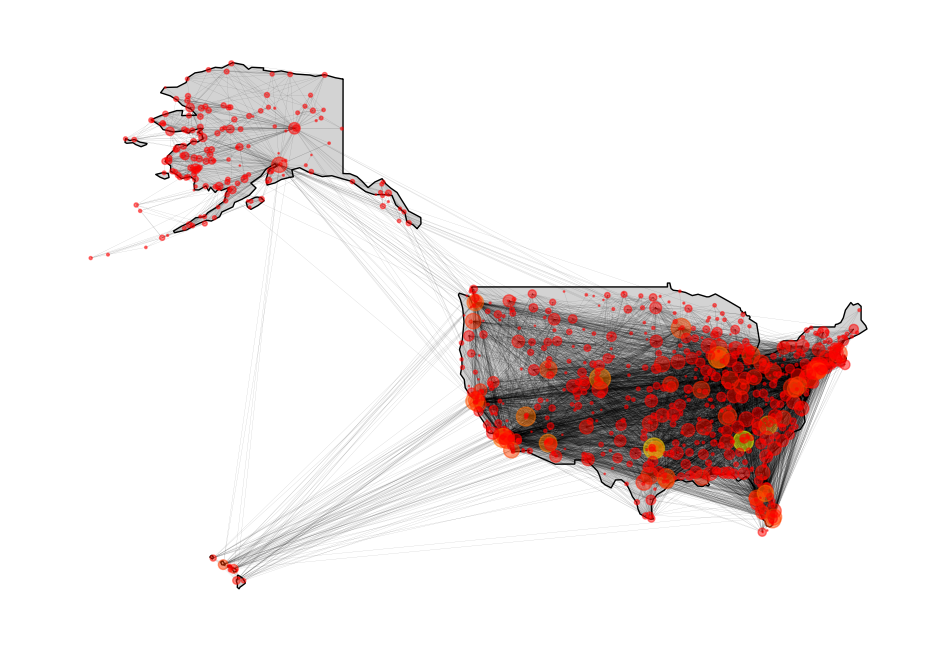

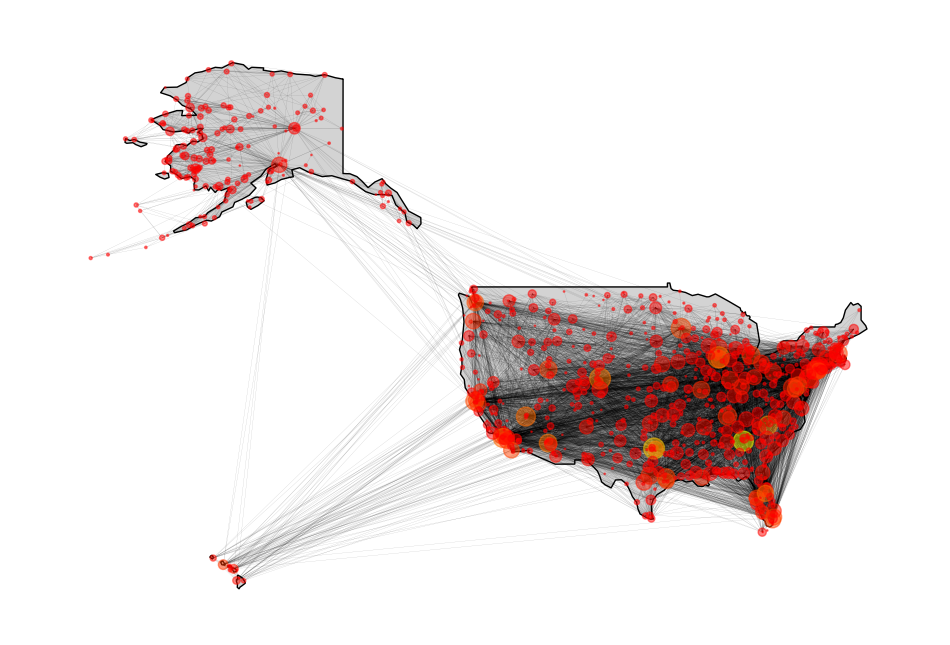

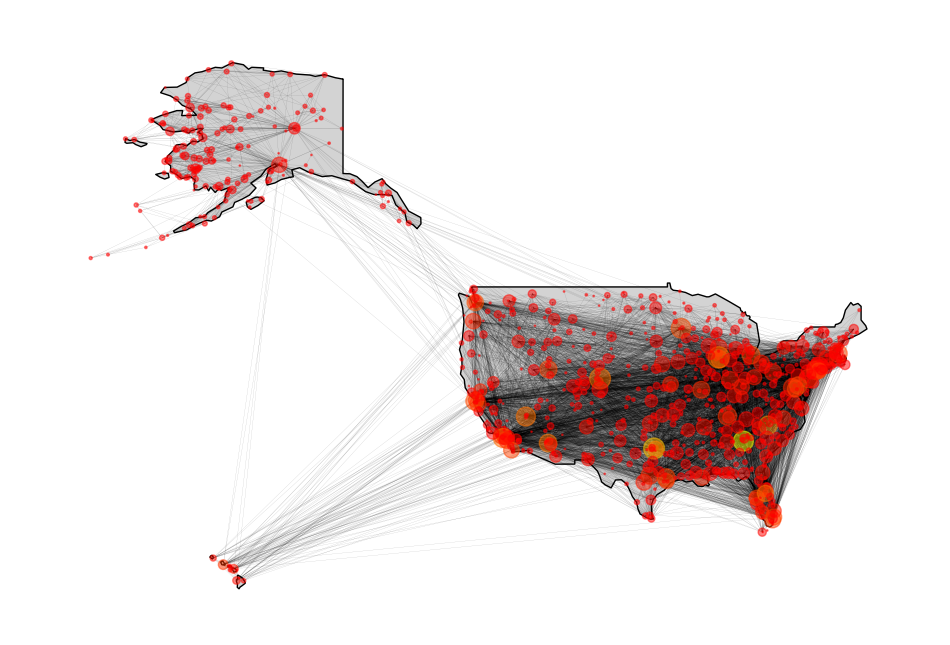

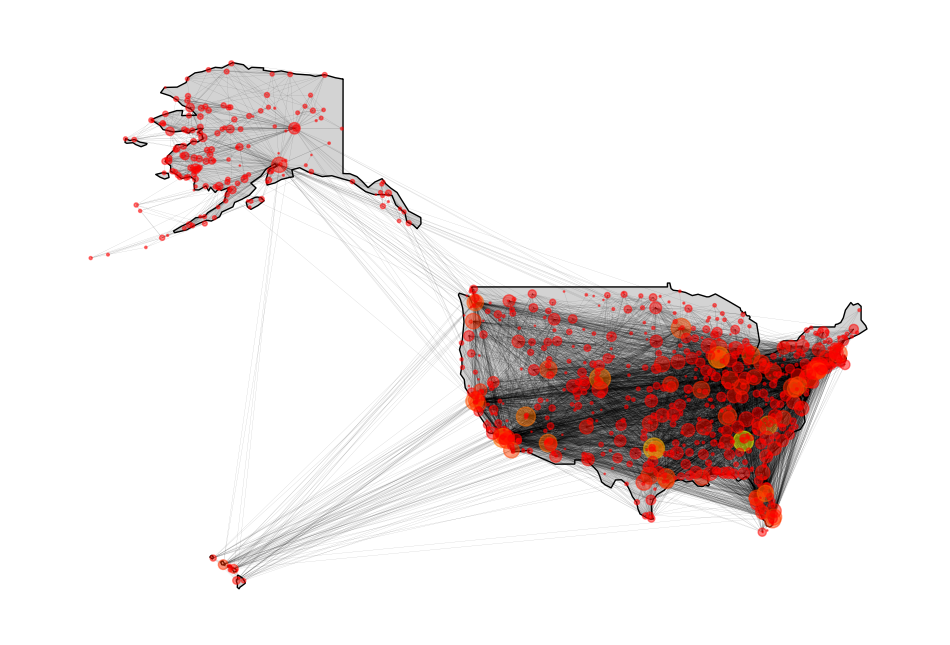

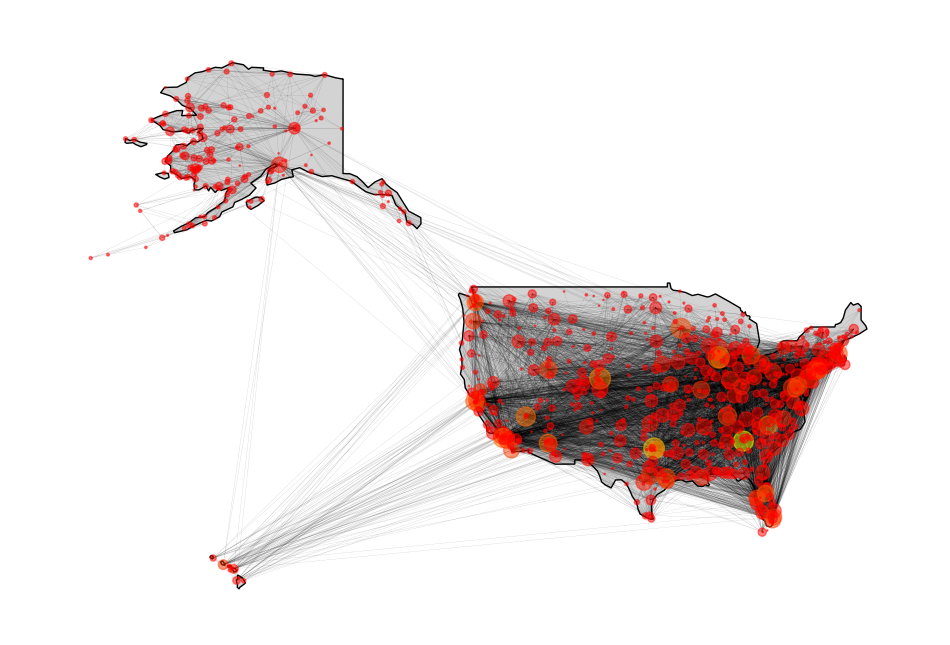

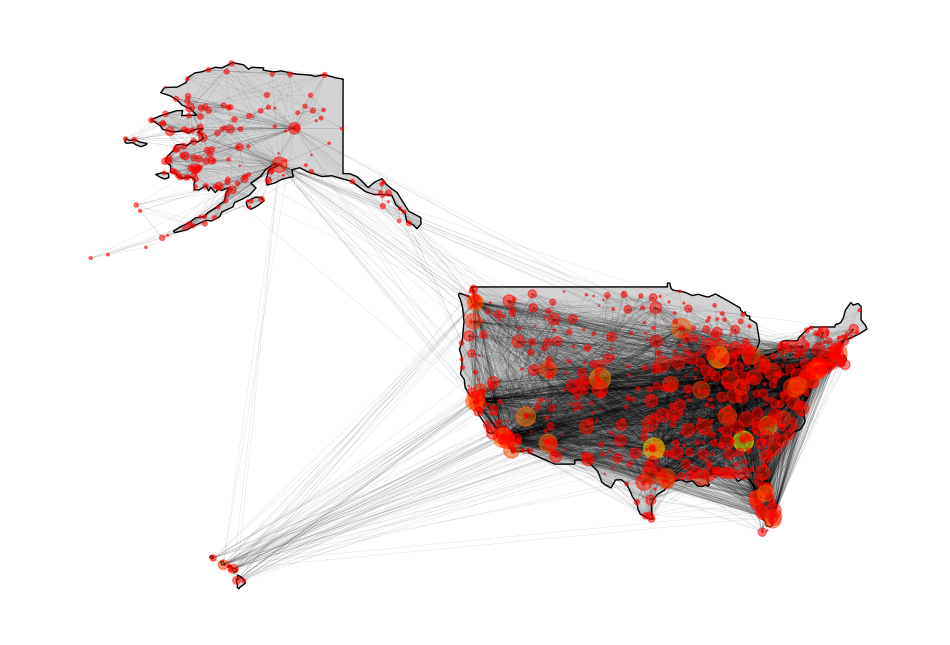

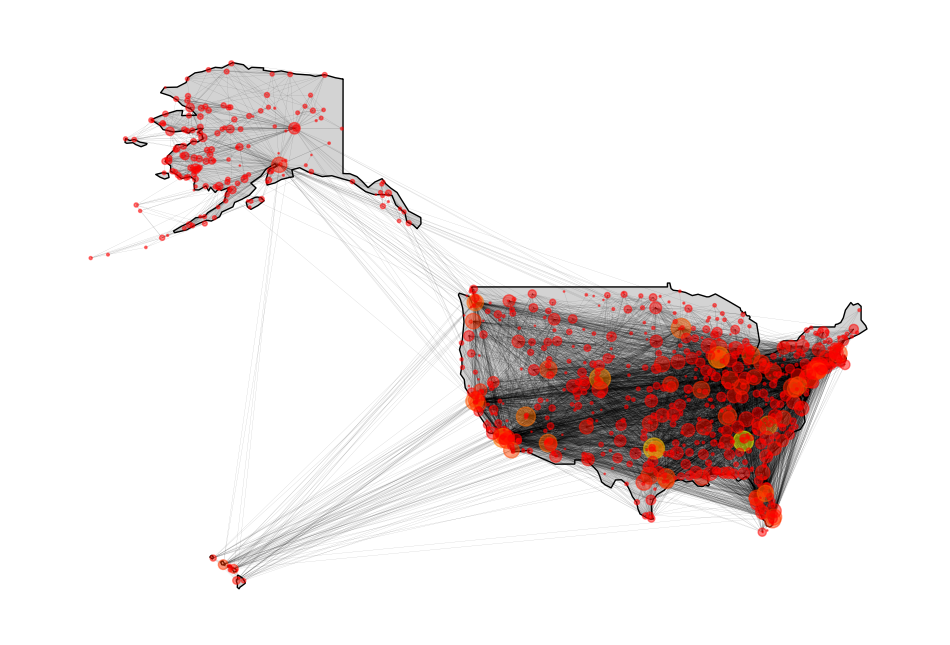

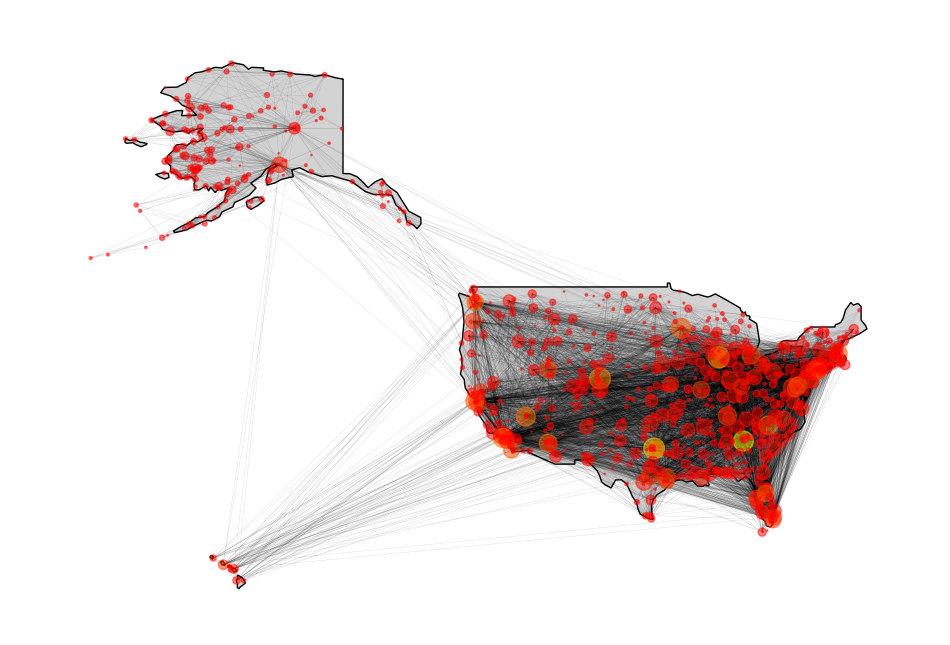

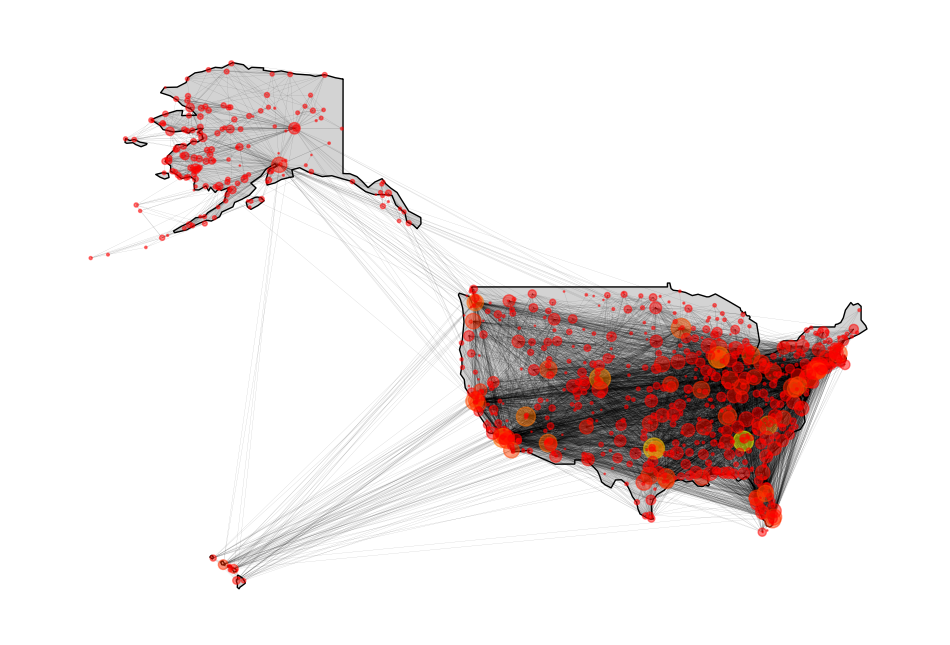

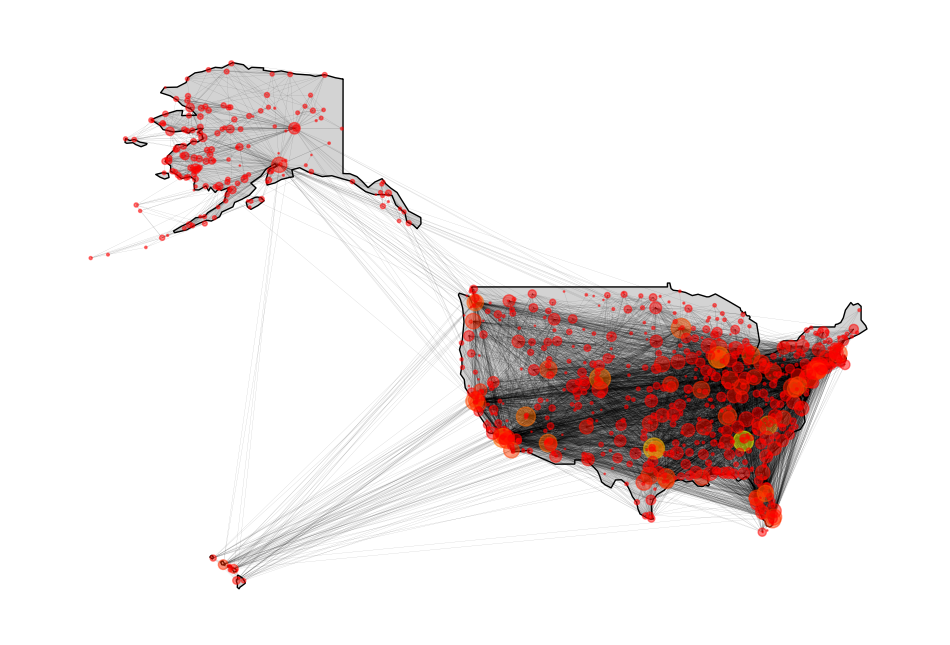

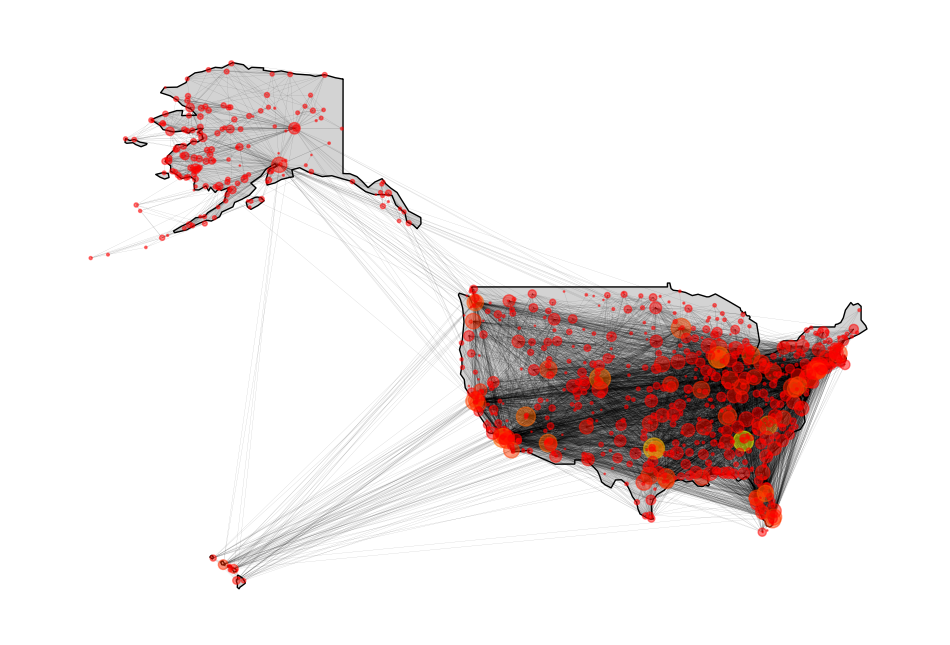

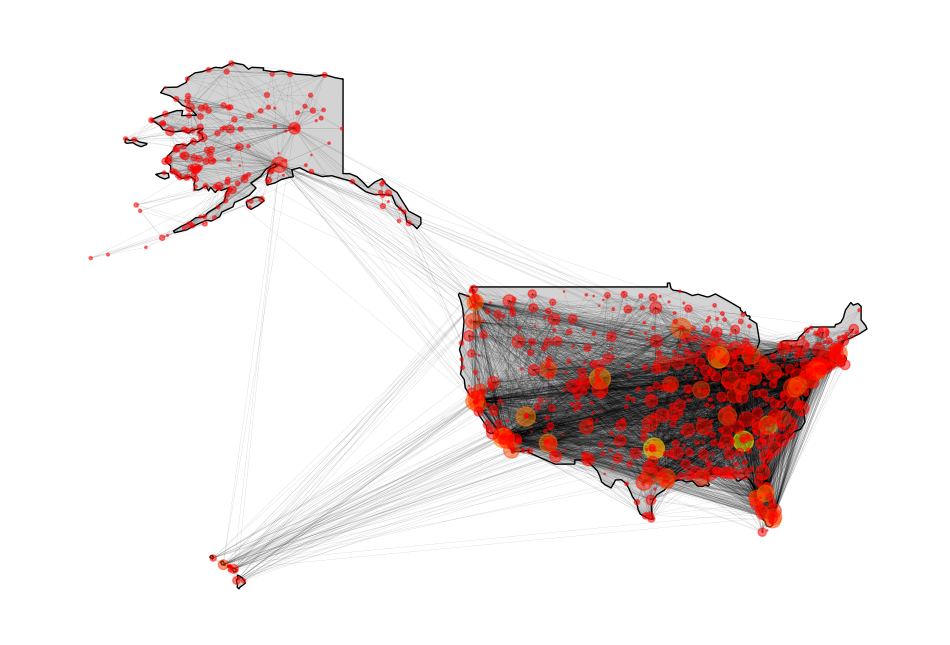

In [150]:
for k, v in temporal_networks_in_degrees.items():
    # Map projection
    fig, ax = plt.subplots(figsize=(12, 9))
    countries = gpd.read_file(
                  gpd.datasets.get_path("naturalearth_lowres"))
    usa.plot(ax=ax, color='lightgray', edgecolor='black')
    node_color = [v[n] if n in v.keys() else 0 for n in spatial_network.nodes()]
    nx.draw_networkx(spatial_network, ax=ax,
                    node_color=node_color,
                    font_size=3,
                    alpha=.5,
                    width=.075,
                    node_size=deg_sizes,
                    labels=labels,
                    pos=pos,
                    cmap=plt.cm.autumn)

    # Customize the plot appearance
    ax.set_axis_off()

    # Show the plot
    plt.show()

In [ ]:
temporal_networks_betweenness = {
    k: get_nodes_betweenness_centrality(v, weight='passengers', normalize=False)
    for k, v in temporal_networks_dict.items()
}

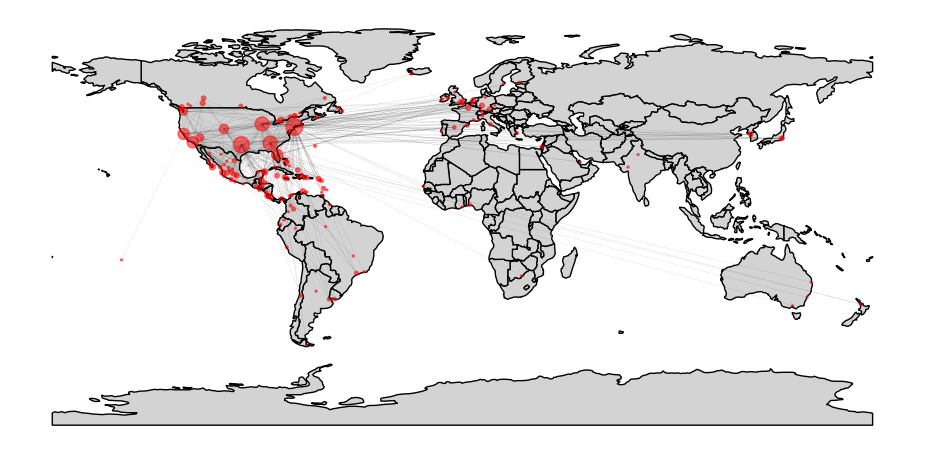

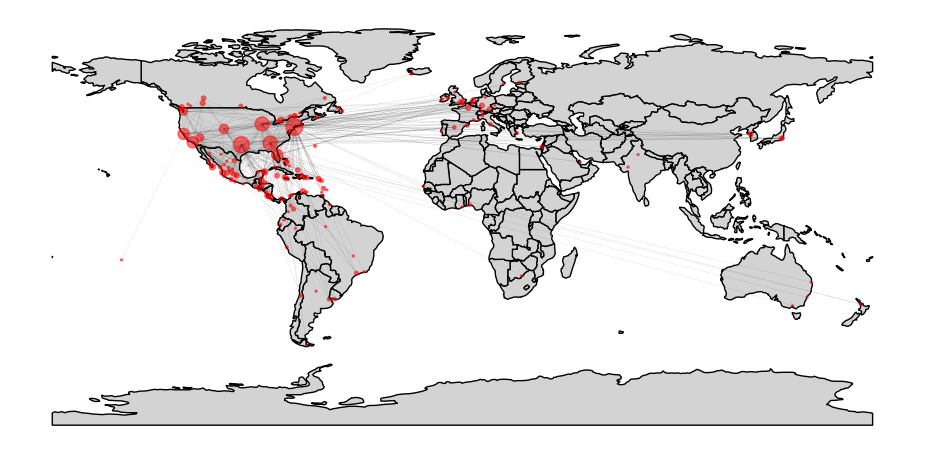

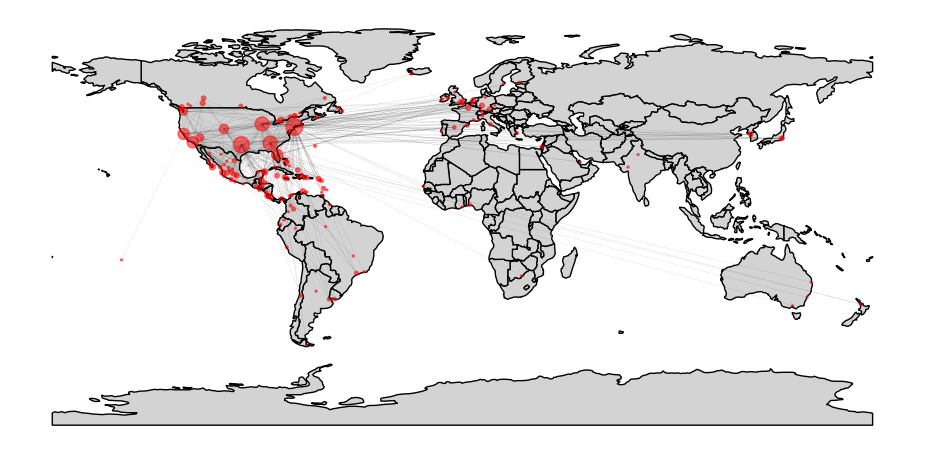

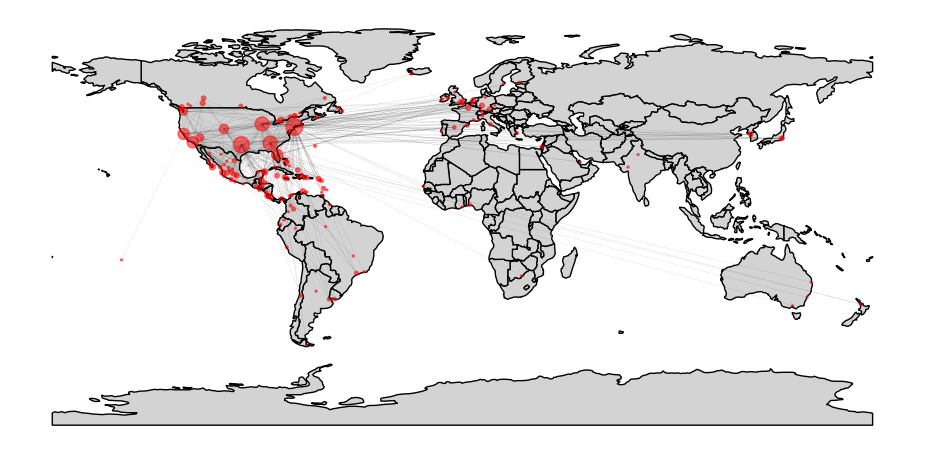

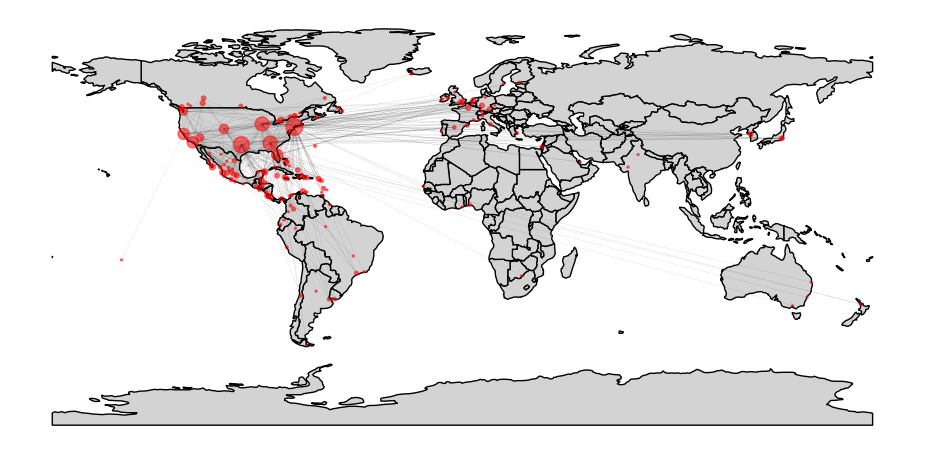

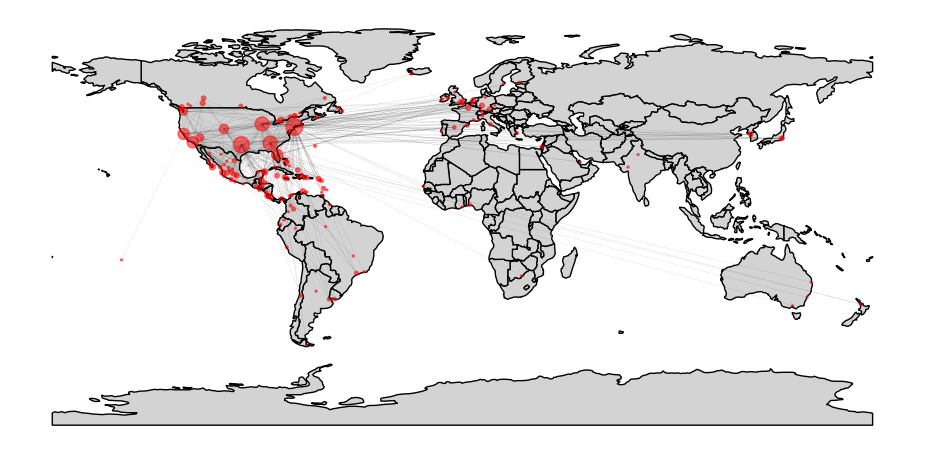

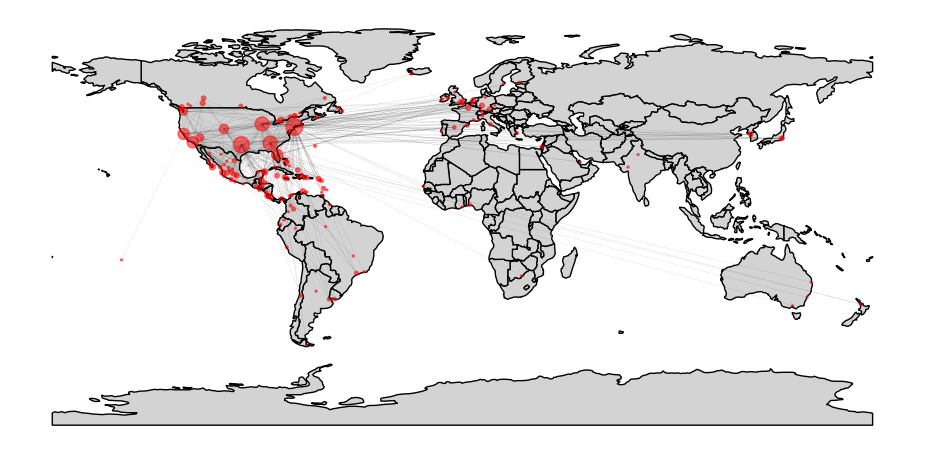

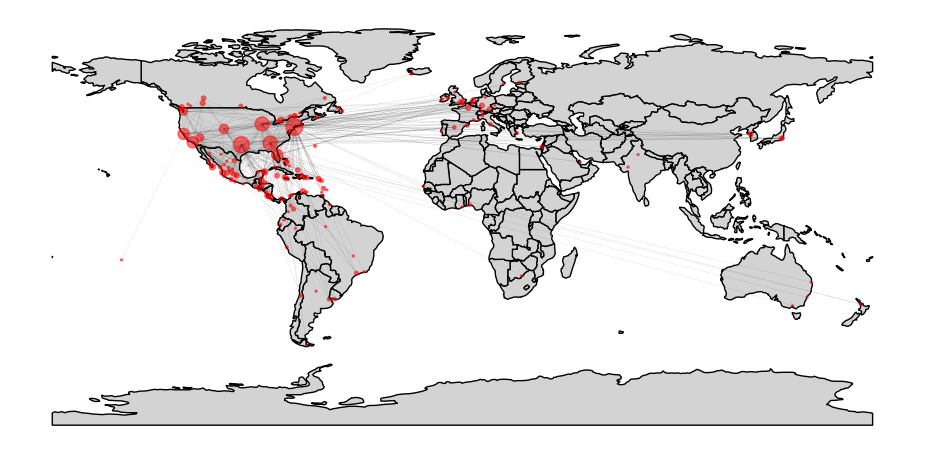

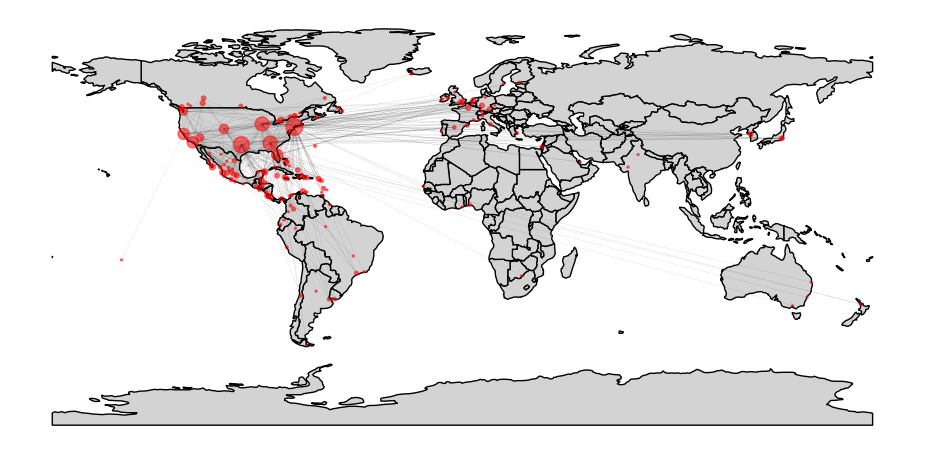

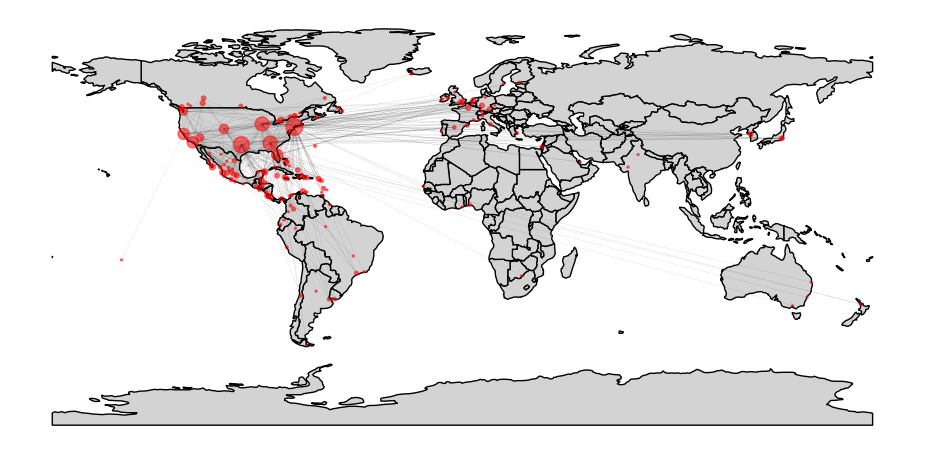

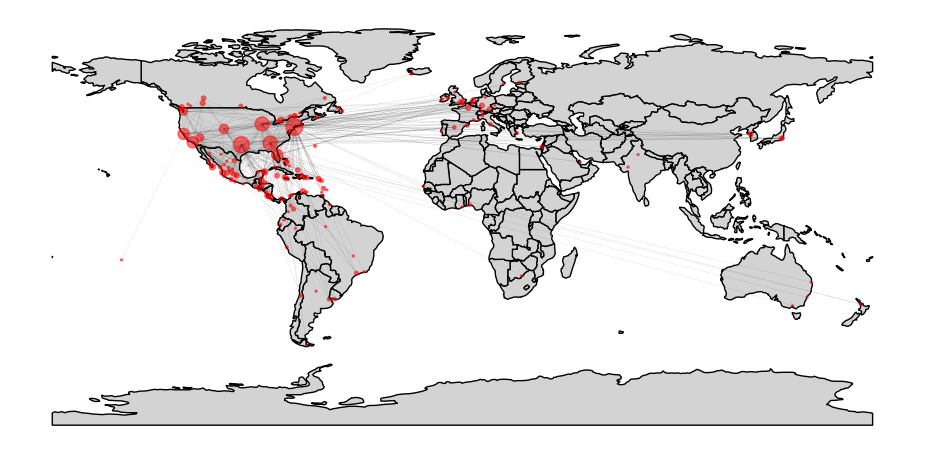

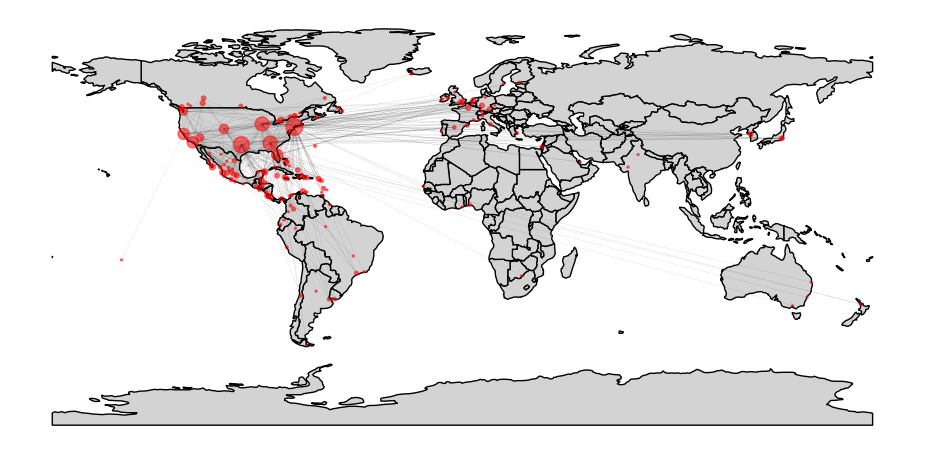

In [ ]:
for k, v in temporal_networks_betweenness.items():
    # Map projection
    fig, ax = plt.subplots(figsize=(12, 9))
    countries = gpd.read_file(
                  gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(ax=ax, color='lightgray', edgecolor='black')
    node_color = [v[n] if n in v.keys() else 0 for n in spatial_network.nodes()]
    nx.draw_networkx(spatial_network, ax=ax,
                    node_color=node_color,
                    font_size=3,
                    alpha=.5,
                    width=.075,
                    node_size=sizes,
                    labels=labels,
                    pos=pos,
                    cmap=plt.cm.autumn)

    # Customize the plot appearance
    ax.set_axis_off()

    # Show the plot
    plt.show()